# Ejercicio Caso 1
## Todos los vehiculos con la misma capacidad

### Integrantes:
- David Betancur
- Daniel Salazar
- Pablo García

### Problema:
Una empresa de entregas debe optimizar las rutas de sus vehículos para entregar paquetes a una serie de clientes distribuidos en una ciudad. El objetivo es minimizar la distancia total recorrida por todos los vehículos, respetando las restricciones de capacidad de los vehículos y asegurando que todas las entregas se completen de manera eficiente.

#### Detalles del Problema:
- **Clientes:**
Hay n clientes, cada uno con una ubicación específica representada por coordenadas (x, y)
en un plano 2D.
Cada cliente tiene una demanda de entrega, que representa la cantidad de paquetes que
necesita recibir.
- **Depósito:**
Hay un único depósito donde todos los vehículos inician y terminan su recorrido.
- **Vehículos:**
La empresa cuenta con m vehículos, cada uno con una capacidad máxima de carga.
Los vehículos deben comenzar y terminar su ruta en el depósito.
- **Distancia:**
La distancia entre dos puntos (ya sea entre dos clientes o entre un cliente y el depósito) se
calcula utilizando la distancia euclidiana.
- **Ruta:**
Cada vehículo sigue una ruta que comienza y termina en el depósito, visitando un conjunto
de clientes de manera que la demanda total de los clientes en la ruta no exceda la capacidad
del vehículo.
- **Restricciones:**
Cada cliente debe ser visitado exactamente una vez por uno de los vehículos.
La capacidad de cada vehículo no debe ser excedida.

#### Objetivo:
Minimizar la distancia total recorrida por todos los vehículos.

#### Entrega:
Una presentación de no más de 10 minutos donde expongan la descripción del problema, el detalle
de la función de adaptabilidad y la interpretación del resultado.

# Importar librerías

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
import math

#Advertencias
import warnings
warnings.filterwarnings('ignore')

## Stats

In [34]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('Promedio', np.mean)
stats.register('Desviación Estándar', np.std)
stats.register('Mínimo', np.min)
stats.register('Máximo', np.max)

## Configuración de parámetros inicales que se utilizan después cuando se llama al método

In [35]:
MAX_CLIENTES = 20                 # Número maximo de clientes
MIN_DEMANDA_CLIENTE = 1           # Demanda mínima de cada cliente
MAX_DEMANDA_CLIENTE = 20          # Demanda máxima de cada cliente

MAX_VEHICULOS = 5                 # Número maximo de vehículos
MIN_CAPACIDAD_VEHICULO = 40       # Capacidad mínima de cada vehículo
MAX_CAPACIDAD_VEHICULO = 80      # Capacidad máxima de cada vehículo

TAMANO_POBLACION = 300            # Tamaño de la población
MAX_GENERACIONES = 500            # Número máximo de generaciones
PROBABILIDAD_CRUCE = 0.9          # Probabilidad de cruce
PROBABILIDAD_MUTACION = 0.1       # Probabilidad de mutación

TAMANO_MAPA = 100                 # Tamaño del mapa

In [36]:
# Número de vehiculos
NUM_VEHICULOS = random.randint(3, MAX_VEHICULOS)

# Número de clientes
NUM_CLIENTES = random.randint(NUM_VEHICULOS, MAX_CLIENTES)

## Clases para representar a los Clientes, el Depósito y los Vehículos

In [37]:
# Clase para representar un cliente
class Cliente:
  def __init__(self, id, x, y, demanda):
    self.id = id
    self.x = x
    self.y = y
    self.demanda = demanda

  def __str__(self):
    return f"Cliente(id={self.id}, x={self.x}, y={self.y}, demanda={self.demanda})"

# Clase para representar el depósito
class Deposito:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.id = 0

  def __str__(self):
    return f"Deposito(id={self.id}, x={self.x}, y={self.y})"

# Clase para representar un vehículo
class Vehiculo:
  def __init__(self, capacidad):
    self.capacidad = capacidad
    self.carga_actual = 0
    self.ruta = []

  def __str__(self):
    return f"Vehiculo(capacidad={self.capacidad}, carga_actual={self.carga_actual}, ruta={self.ruta})"

## Función para calcular la distancia euclidiana entre dos puntos

In [38]:
def calcular_distancia(punto1, punto2):
    return math.sqrt((punto1.x - punto2.x)**2 + (punto1.y - punto2.y)**2)

## Generar ubicación de los clientes aleatoriamente

In [39]:
# Generar clientes aleatorios en el mapa
# con coordenadas (x, y) y una demanda aleatoria
def generar_clientes(num_clientes, deposito):
    clientes = []
    coordenadas_usadas = set()

    while len(clientes) < num_clientes:
        x = int(random.uniform(0, TAMANO_MAPA))
        y = int(random.uniform(0, TAMANO_MAPA))

        # Validar que el cliente no esté en la posición del depósito
        # y que no tenga las mismas coordenadas que otro cliente
        if (x, y) != (deposito.x, deposito.y) and (x, y) not in coordenadas_usadas:
            demanda = random.randint(MIN_DEMANDA_CLIENTE, MAX_DEMANDA_CLIENTE)
            cliente = Cliente(len(clientes), x, y, demanda)
            clientes.append(cliente)
            coordenadas_usadas.add((x, y))

    return clientes

In [40]:
# Generar el depósito en el centro del mapa
deposito = Deposito(TAMANO_MAPA / 2, TAMANO_MAPA / 2)

# Generar clientes aleatorios
clientes = generar_clientes(NUM_CLIENTES, deposito)

## Generar vehiculos con diferentes capacidades

In [41]:
def generar_vehiculos(num_vehiculos):
    vehiculos = []
    for _ in range(num_vehiculos):
        capacidad = random.randint(MIN_CAPACIDAD_VEHICULO, MAX_CAPACIDAD_VEHICULO)
        vehiculos.append(Vehiculo(capacidad))
    return vehiculos

In [42]:
vehiculos = generar_vehiculos(NUM_VEHICULOS)

# Verificar si la demanda total es mayor que la capacidad total
while sum(cliente.demanda for cliente in clientes) > sum(vehiculo.capacidad for vehiculo in vehiculos):
    # Generar vehiculo adicional
    vehiculo = generar_vehiculos(1)[0]
    vehiculos.append(vehiculo)

NUM_VEHICULOS = len(vehiculos)

## Evaluamos la aptitud de un individuo

In [43]:
def evaluar_individuo(individuo, clientes, deposito, capacidad_vehiculo):
    total_distancia = 0
    carga_actual = 0
    posicion_actual = deposito

    for cliente_id in individuo:
        cliente = next(c for c in clientes if c.id == cliente_id)

        if carga_actual + cliente.demanda > capacidad_vehiculo:
            # Volver al depósito
            total_distancia += calcular_distancia(posicion_actual, deposito)
            # Reiniciar ruta
            carga_actual = 0
            posicion_actual = deposito

        # Ir al cliente
        total_distancia += calcular_distancia(posicion_actual, cliente)
        carga_actual += cliente.demanda
        posicion_actual = cliente

    # Regresar al depósito al final
    total_distancia += calcular_distancia(posicion_actual, deposito)

    return (total_distancia,)  # DEAP requiere que fitness sea una tupla

## Declarar los artefactos genéticos

In [44]:
#Contenedor de las operaciones genéticas
toolbox = base.Toolbox()

## Creación de los individuos

In [45]:
ids_clientes = [cliente.id for cliente in clientes]

def crear_individuo():
    individuo = ids_clientes[:]
    random.shuffle(individuo)
    return individuo

## Se define el problema como minimización

In [46]:
# Definir el problema como minimización
creator.create('FitnessMin', base.Fitness, weights = (-1.0,))
creator.create('Individual', list, fitness = creator.FitnessMin)

## Registramos las funciones

In [47]:
toolbox.register("individual", tools.initIterate, creator.Individual, crear_individuo)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluar_individuo, clientes=clientes, deposito=deposito, capacidad_vehiculo=MAX_CAPACIDAD_VEHICULO)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

## Creamos la población inicial

In [48]:
poblacion = toolbox.population(n=TAMANO_POBLACION)

## Ejecutamos el algoritmo tratando de obtener el mejor individuo

In [49]:
resultado, log = algorithms.eaSimple(poblacion, toolbox,
                                     cxpb=PROBABILIDAD_CRUCE,
                                     mutpb=PROBABILIDAD_MUTACION,
                                     ngen=MAX_GENERACIONES,
                                     stats=stats,
                                     verbose=True)

# Obtener el mejor individuo
mejor = tools.selBest(resultado, 1)[0]

gen	nevals	Promedio	Desviación Estándar	Mínimo 	Máximo 
0  	300   	1085.17 	86.8907            	775.665	1287.42
1  	269   	1056    	86.9625            	771.448	1283.48
2  	281   	1049.46 	89.2198            	812.082	1351.04
3  	261   	1036.9  	93.5236            	838.44 	1323.02
4  	279   	1031.38 	94.9686            	817.09 	1300.63
5  	269   	1030.29 	89.4774            	817.09 	1275.34
6  	284   	1031.53 	90.3964            	810.249	1266.66
7  	276   	1019.79 	87.0336            	804.372	1254.05
8  	267   	1017.59 	88.6459            	804.372	1262.96
9  	274   	1018.32 	94.2348            	785.523	1269.21
10 	270   	1021.34 	90.6351            	816.609	1235.82
11 	278   	1032.66 	98.3539            	770    	1305.69
12 	276   	1012.53 	94.6712            	709.785	1241.05
13 	275   	1014.97 	94.3025            	745.181	1280.97
14 	275   	1021    	99.3774            	741.786	1242.75
15 	272   	1019.27 	100.892            	740.388	1265.89
16 	282   	1021.67 	99.5725            	740.388	

## Proceso generacional y Visualización

### Funciones

In [50]:
def graficar_solucion(individuo, clientes, deposito, capacidad_vehiculo):
    plt.figure(figsize=(10, 8))

    # Dibujar clientes
    for cliente in clientes:
        plt.plot(cliente.x, cliente.y, 'bo')
        plt.text(cliente.x + 1, cliente.y + 1, f'C{cliente.id}', fontsize=9)

    # Dibujar depósito
    plt.plot(deposito.x, deposito.y, 'rs', markersize=10, label='Depósito')

    colores = ['g', 'm', 'c', 'y', 'orange', 'purple', 'brown', 'pink']
    color_index = 0

    carga_actual = 0
    ruta_x = [deposito.x]
    ruta_y = [deposito.y]

    for cliente_id in individuo:
        cliente = next(c for c in clientes if c.id == cliente_id)

        if carga_actual + cliente.demanda > capacidad_vehiculo:
            # Cerrar ruta y graficar
            ruta_x.append(deposito.x)
            ruta_y.append(deposito.y)
            plt.plot(ruta_x, ruta_y, '-', color=colores[color_index % len(colores)], linewidth=2, label=f'Vehículo {color_index+1}')

            # Reiniciar ruta
            ruta_x = [deposito.x]
            ruta_y = [deposito.y]
            carga_actual = 0
            color_index += 1

        # Añadir cliente a la ruta actual
        ruta_x.append(cliente.x)
        ruta_y.append(cliente.y)
        carga_actual += cliente.demanda

    # Dibujar la última ruta
    ruta_x.append(deposito.x)
    ruta_y.append(deposito.y)
    plt.plot(ruta_x, ruta_y, '-', color=colores[color_index % len(colores)], linewidth=2, label=f'Vehículo {color_index+1}')

    plt.title('Rutas óptimas encontradas')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()

    # Ajustar límites del gráfico
    plt.xlim(0, TAMANO_MAPA)
    plt.ylim(0, TAMANO_MAPA)

    plt.show()

In [51]:
def obtener_rutas_por_vehiculo(individuo, clientes, capacidad_vehiculo):
    rutas = []
    ruta_actual = []
    carga_actual = 0

    for cliente_id in individuo:
        cliente = next(c for c in clientes if c.id == cliente_id)

        if carga_actual + cliente.demanda > capacidad_vehiculo:
            rutas.append(ruta_actual)
            ruta_actual = []
            carga_actual = 0

        ruta_actual.append(cliente_id)
        carga_actual += cliente.demanda

    if ruta_actual:
        rutas.append(ruta_actual)

    return rutas

### Usar funciones

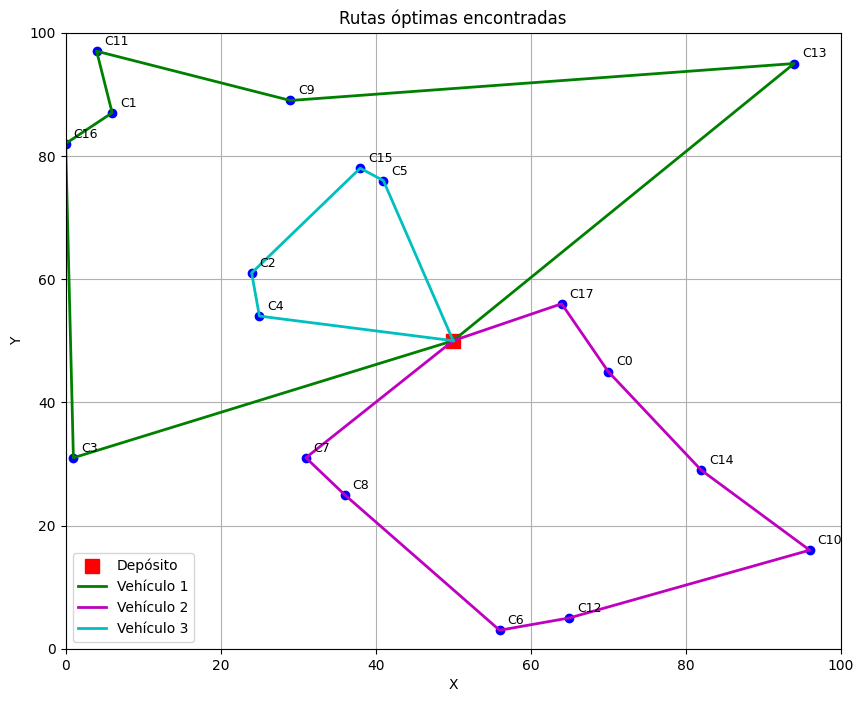

In [52]:
mejor = tools.selBest(resultado, 1)[0]
graficar_solucion(mejor, clientes, deposito, MAX_CAPACIDAD_VEHICULO)

In [53]:
rutas = obtener_rutas_por_vehiculo(mejor, clientes, MAX_CAPACIDAD_VEHICULO)

for i, ruta in enumerate(rutas):
    print(f"Vehículo {i + 1}: Clientes {ruta}")

Vehículo 1: Clientes [13, 9, 11, 1, 16, 3]
Vehículo 2: Clientes [7, 8, 6, 12, 10, 14, 0, 17]
Vehículo 3: Clientes [4, 2, 15, 5]
